In [3]:
# IMPORT LIBRARIES
import os
import sys
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas import set_option
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import seaborn as sns
%matplotlib inline 

# from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# import performance metrics/measures
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# from imblearn.under_sampling import KMeansSMOTE
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

In [4]:
# VARIABLES

# created a .csv version of the original dataset (.xls)
INPUT_PATH = "credit.csv"
# SCALER = 'std'  # else 'minmax'

SHOW_FIGURE = True 

# preprocessing
FEATURE_SELECTION = False  # if 'True' Feature Selection will be applied (i.e. 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6' will be removed)
APPLY_PCA = False                # if 'True' Principal Component Analysis will be applied
APPLY_OVERSAMPLING = False       # if 'True' SMOTE Oversampling will be applied

RANDOM_STATE = None   # fixed in order to have comparable results

# Pandas options
set_option('display.max_colwidth', None)
set_option('precision', 2)

In [5]:
# read input
data = pd.read_csv(INPUT_PATH)
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


/Users/saipraneethapathakamuri/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


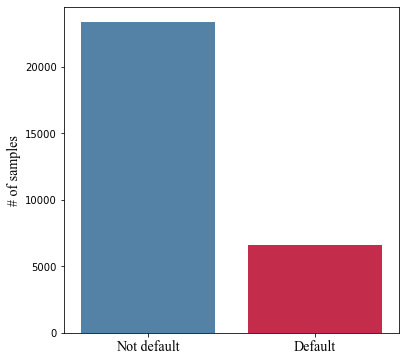

In [6]:
# Dataset balanced?
if SHOW_FIGURE :
    font = FontProperties()
    font.set_family(['Times New Roman', 'serif'])
    font.set_size(14)

    plt.figure(figsize = (6,6))
    sns.countplot('default payment next month', data=data, palette=['steelblue','crimson'])
    # plt.title('Class Distribution Histogram', fontsize=14)
    plt.xticks([0,1],['Not default','Default'],fontproperties=font)
    plt.ylabel('# of samples', fontproperties=font)
    plt.xlabel('')
    # plt.show()
    plt.savefig('Fig - Class Distribution Histogram.png')

In [7]:
# Check data types 
data.dtypes

ID                            int64
LIMIT_BAL                     int64
SEX                           int64
EDUCATION                     int64
MARRIAGE                      int64
AGE                           int64
PAY_0                         int64
PAY_2                         int64
PAY_3                         int64
PAY_4                         int64
PAY_5                         int64
PAY_6                         int64
BILL_AMT1                     int64
BILL_AMT2                     int64
BILL_AMT3                     int64
BILL_AMT4                     int64
BILL_AMT5                     int64
BILL_AMT6                     int64
PAY_AMT1                      int64
PAY_AMT2                      int64
PAY_AMT3                      int64
PAY_AMT4                      int64
PAY_AMT5                      int64
PAY_AMT6                      int64
default payment next month    int64
dtype: object

In [8]:
# Check missing values: no as can be also seen with data.info()
data.isnull().values.any()


False

In [9]:
# Summary Statistics
data.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00,...,30000.00,30000.00,30000.00,30000.00,3.00e+04,30000.00,30000.00,30000.00,30000.00,30000.00
mean,15000.50,167484.32,1.60,1.85,1.55,35.49,-0.02,-0.13,-0.17,-0.22,...,43262.95,40311.40,38871.76,5663.58,5.92e+03,5225.68,4826.08,4799.39,5215.50,0.22
std,8660.40,129747.66,0.49,0.79,0.52,9.22,1.12,1.20,1.20,1.17,...,64332.86,60797.16,59554.11,16563.28,2.30e+04,17606.96,15666.16,15278.31,17777.47,0.42
min,1.00,10000.00,1.00,0.00,0.00,21.00,-2.00,-2.00,-2.00,-2.00,...,-170000.00,-81334.00,-339603.00,0.00,0.00e+00,0.00,0.00,0.00,0.00,0.00
25%,7500.75,50000.00,1.00,1.00,1.00,28.00,-1.00,-1.00,-1.00,-1.00,...,2326.75,1763.00,1256.00,1000.00,8.33e+02,390.00,296.00,252.50,117.75,0.00
50%,15000.50,140000.00,2.00,2.00,2.00,34.00,0.00,0.00,0.00,0.00,...,19052.00,18104.50,17071.00,2100.00,2.01e+03,1800.00,1500.00,1500.00,1500.00,0.00
75%,22500.25,240000.00,2.00,2.00,2.00,41.00,0.00,0.00,0.00,0.00,...,54506.00,50190.50,49198.25,5006.00,5.00e+03,4505.00,4013.25,4031.50,4000.00,0.00
max,30000.00,1000000.00,2.00,6.00,3.00,79.00,8.00,8.00,8.00,8.00,...,891586.00,927171.00,961664.00,873552.00,1.68e+06,896040.00,621000.00,426529.00,528666.00,1.00


In [10]:
# rename variable 'PAY_0' to 'PAY_1' 
data.rename(columns={"PAY_0": "PAY_1"}, inplace=True)
# rename target variable: 'default.payment.next.month' to 'Default'
data.rename(columns={"default payment next month": "Default"}, inplace=True)
# drop first attribute "ID"
data.drop('ID', axis = 1, inplace =True)
# Class label to category
data["Default"] = data["Default"].astype('category')

In [11]:
data['MARRIAGE'].value_counts()

2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64

In [12]:
data.loc[data.MARRIAGE == 0, 'MARRIAGE'] = 3
data.MARRIAGE.value_counts()

2    15964
1    13659
3      377
Name: MARRIAGE, dtype: int64

In [13]:
data['EDUCATION'].value_counts()

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

In [14]:
fil = (data.EDUCATION == 5) | (data.EDUCATION == 6) | (data.EDUCATION == 0)
data.loc[fil, 'EDUCATION'] = 4
data.EDUCATION.value_counts()

2    14030
1    10585
3     4917
4      468
Name: EDUCATION, dtype: int64

In [15]:
# category '0' undocumented is deleted
data = data.drop(data[data['MARRIAGE']==0].index)
# we could also group the 0 category with 3:others
# data['MARRIAGE']=np.where(data['MARRIAGE'] == 0, 3, data['MARRIAGE'])

# categories 0, 5 and 6 are unknown and are deleted
data = data.drop(data[data['EDUCATION']==0].index)
data = data.drop(data[data['EDUCATION']==5].index)
data = data.drop(data[data['EDUCATION']==6].index)
# we could also group the categories together
# data['EDUCATION']=np.where(data['EDUCATION'] == 5, 4, data['EDUCATION'])
# data['EDUCATION']=np.where(data['EDUCATION'] == 6, 4, data['EDUCATION'])
# data['EDUCATION']=np.where(data['EDUCATION'] == 0, 4, data['EDUCATION'])

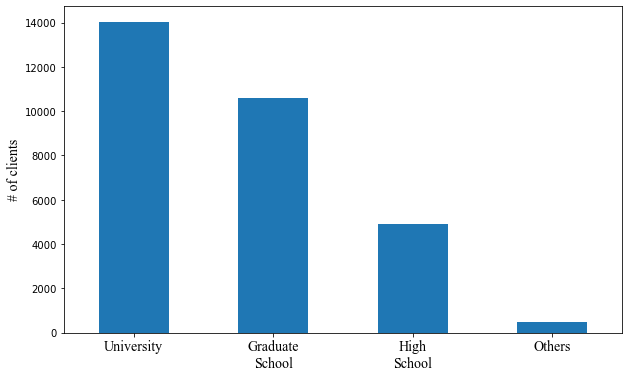

In [16]:
if SHOW_FIGURE :
    # 1=graduate school, 2=university, 3=high school 4=others
    data['EDUCATION'].value_counts().plot(kind='bar', figsize=(10,6))
    # plt.title("Number of cars by make")
    plt.xticks([0,1,2,3],['University','Graduate\nSchool', 'High\nSchool', 'Others'],fontproperties=font,rotation=0)
    # plt.xlabel('Education level', fontproperties=font)
    plt.ylabel('# of clients', fontproperties=font)
    # plt.show()
    plt.savefig('Fig - Education Level barplot.png')

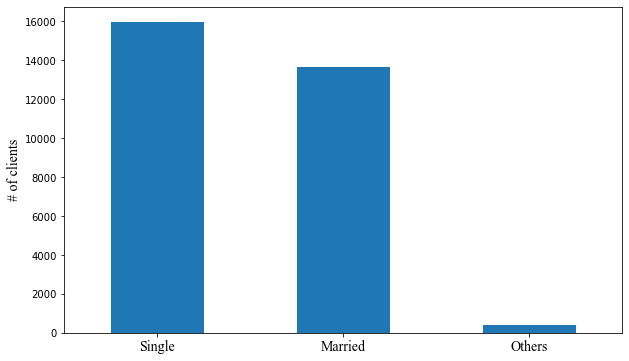

In [17]:
if SHOW_FIGURE :
    # 1=married, 2=single, 3=others
    data['MARRIAGE'].value_counts().plot(kind='bar', figsize=(10,6))
    # plt.title("Number of cars by make")
    plt.xticks([0,1,2],['Single','Married', 'Others'],fontproperties=font,rotation=0)
    # plt.xlabel('Marital Status', fontproperties=font)
    plt.ylabel('# of clients', fontproperties=font)
    # plt.show()
    plt.savefig('Fig - Marital Status.png')

In [18]:
# Payment delay description
data[['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']].describe()

,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
count,30000.00,30000.00,30000.00,30000.00,30000.00,30000.00
mean,-0.02,-0.13,-0.17,-0.22,-0.27,-0.29
std,1.12,1.20,1.20,1.17,1.13,1.15
min,-2.00,-2.00,-2.00,-2.00,-2.00,-2.00
25%,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00
50%,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.00,0.00,0.00,0.00,0.00,0.00
max,8.00,8.00,8.00,8.00,8.00,8.00


In [19]:
# REPAYMENT STATUS = -1=pay duly, 1=payment delay for one month, 2=payment delay for two months, ... 8=payment delay for eight months, 9=payment delay for nine months and above
# for att in ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']: 
#   print(f"# {att} -------")
#   print(data[att].value_counts())

In [20]:
# since PAY_n can take as values only -1,1,2,3,4,5,6,7,8,9
for att in ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']:
  # categories -2,-1 are grouped into a single class -1: pay duly   
  filter = (data[att] == -2) | (data[att] == -1) 
  data.loc[filter, att] = -1
  # print(data[att].unique())
  # moreover the category 0 is undocumented
  # so each category >= 0 has been updated by adding 1
  data[att] = data[att].astype('int64')
  filter = (data[att] >= 0)
  data.loc[filter, att] = data.loc[filter, att] + 1
  # print(data[att].unique())
  # print("##############################################")

In [21]:
def_pay1_payduly_count = len(data.loc[(data['PAY_1']==-1) & (data['Default']==1)])
nondef_pay1_payduly_count = len(data.loc[(data['PAY_1']==-1) & (data['Default']==0)])

def_pay1_del1_count = len(data.loc[(data['PAY_1']==1) & (data['Default']==1)])
nondef_pay1_del1_count = len(data.loc[(data['PAY_1']==1) & (data['Default']==0)])
def_pay1_del2_count = len(data.loc[(data['PAY_1']==2) & (data['Default']==1)])
nondef_pay1_del2_count = len(data.loc[(data['PAY_1']==2) & (data['Default']==0)])
def_pay1_del3_count = len(data.loc[(data['PAY_1']==3) & (data['Default']==1)])
nondef_pay1_del3_count = len(data.loc[(data['PAY_1']==3) & (data['Default']==0)])
def_pay1_del4_count = len(data.loc[(data['PAY_1']==4) & (data['Default']==1)])
nondef_pay1_del4_count = len(data.loc[(data['PAY_1']==4) & (data['Default']==0)])
def_pay1_del5_count = len(data.loc[(data['PAY_1']==5) & (data['Default']==1)])
nondef_pay1_del5_count = len(data.loc[(data['PAY_1']==5) & (data['Default']==0)])
def_pay1_del6_count = len(data.loc[(data['PAY_1']==6) & (data['Default']==1)])
nondef_pay1_del6_count = len(data.loc[(data['PAY_1']==6) & (data['Default']==0)])
def_pay1_del7_count = len(data.loc[(data['PAY_1']==7) & (data['Default']==1)])
nondef_pay1_del7_count = len(data.loc[(data['PAY_1']==7) & (data['Default']==0)])
def_pay1_del8_count = len(data.loc[(data['PAY_1']==8) & (data['Default']==1)])
nondef_pay1_del8_count = len(data.loc[(data['PAY_1']==8) & (data['Default']==0)])
def_pay1_del9_count = len(data.loc[(data['PAY_1']==9) & (data['Default']==1)])
nondef_pay1_del9_count = len(data.loc[(data['PAY_1']==9) & (data['Default']==0)])

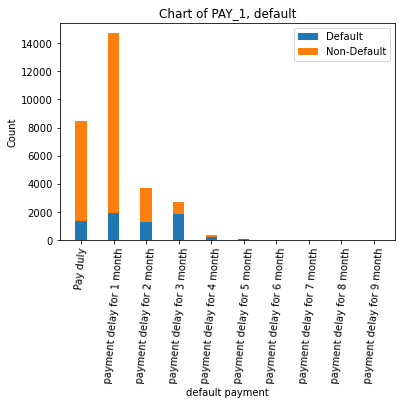

In [22]:
labels = ['Pay duly', 'payment delay for 1 month', 'payment delay for 2 month','payment delay for 3 month','payment delay for 4 month','payment delay for 5 month','payment delay for 6 month','payment delay for 7 month','payment delay for 8 month', 'payment delay for 9 month']
def_count = [def_pay1_payduly_count,def_pay1_del1_count,def_pay1_del2_count,def_pay1_del3_count,def_pay1_del4_count,def_pay1_del5_count,def_pay1_del6_count,def_pay1_del7_count,def_pay1_del8_count,def_pay1_del9_count]
nondef_count = [nondef_pay1_payduly_count,nondef_pay1_del1_count,nondef_pay1_del2_count,nondef_pay1_del3_count,nondef_pay1_del4_count,nondef_pay1_del5_count,nondef_pay1_del6_count,nondef_pay1_del7_count,nondef_pay1_del8_count,nondef_pay1_del9_count]

width = 0.35       # the width of the bars: can also be len(x) sequence


plt.bar(labels, def_count, width, label='Default')
plt.bar(labels, nondef_count, width,bottom=def_count, label='Non-Default')


#fig, ax = plt.subplots()
#ax.bar(df['Manufacturer'], df['Combined MPG'])

plt.xticks(rotation=85)

plt.xlabel('default payment')
plt.ylabel('Count')
plt.title('Chart of PAY_1, default')
plt.legend()
plt.show()

In [23]:
# Bill Statement description
data[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].describe()

,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6
count,30000.00,30000.00,3.00e+04,30000.00,30000.00,30000.00
mean,51223.33,49179.08,4.70e+04,43262.95,40311.40,38871.76
std,73635.86,71173.77,6.93e+04,64332.86,60797.16,59554.11
min,-165580.00,-69777.00,-1.57e+05,-170000.00,-81334.00,-339603.00
25%,3558.75,2984.75,2.67e+03,2326.75,1763.00,1256.00
50%,22381.50,21200.00,2.01e+04,19052.00,18104.50,17071.00
75%,67091.00,64006.25,6.02e+04,54506.00,50190.50,49198.25
max,964511.00,983931.00,1.66e+06,891586.00,927171.00,961664.00


In [24]:
# Previous Payment Description
data[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].describe()

,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,30000.00,3.00e+04,30000.00,30000.00,30000.00,30000.00
mean,5663.58,5.92e+03,5225.68,4826.08,4799.39,5215.50
std,16563.28,2.30e+04,17606.96,15666.16,15278.31,17777.47
min,0.00,0.00e+00,0.00,0.00,0.00,0.00
25%,1000.00,8.33e+02,390.00,296.00,252.50,117.75
50%,2100.00,2.01e+03,1800.00,1500.00,1500.00,1500.00
75%,5006.00,5.00e+03,4505.00,4013.25,4031.50,4000.00
max,873552.00,1.68e+06,896040.00,621000.00,426529.00,528666.00


In [25]:
data.LIMIT_BAL.describe()

count      30000.00
mean      167484.32
std       129747.66
min        10000.00
25%        50000.00
50%       140000.00
75%       240000.00
max      1000000.00
Name: LIMIT_BAL, dtype: float64

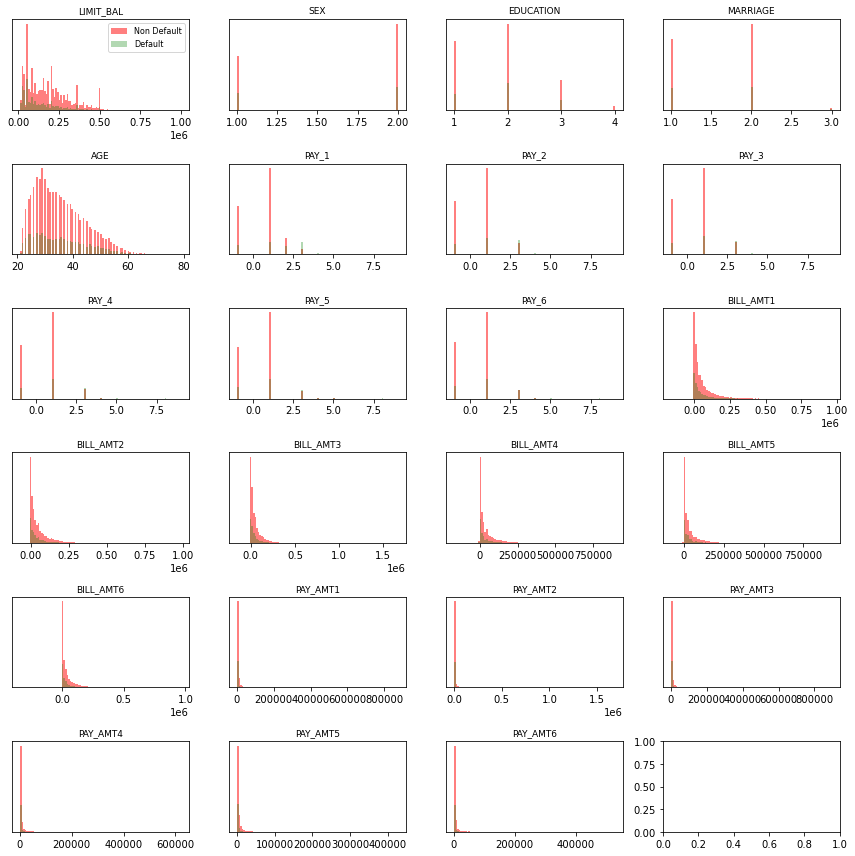

In [26]:
if SHOW_FIGURE :
    # HISTOGRAMS PLOTS FOR FEATURES IMPORTANCE
    fig, axes= plt.subplots(6,4, figsize=(12,12))
    non_def = data[data.Default==0]
    default = data[data.Default==1]
    ax = axes.ravel()

    for i,label in enumerate(data.columns[:-1]):
        _,bins = np.histogram(data[label],bins=100)
        ax[i].hist(non_def[label],bins=bins,color='r',alpha=.5)# red color for malignant class
        ax[i].hist(default[label],bins=bins,color='g',alpha=0.3)# alpha is for transparency in the overlapped region
        ax[i].set_title(data.columns[i],fontsize=9)
        ax[i].axes.get_xaxis().set_visible(True) # the x-axis co-ordinates are not so useful, as we just want to look how well separated the histograms are
        ax[i].set_yticks(())


    ax[0].legend(['Non Default','Default'],loc='best',fontsize=8)
    plt.tight_layout() # let's make good plots
    #plt.show()

<AxesSubplot:>

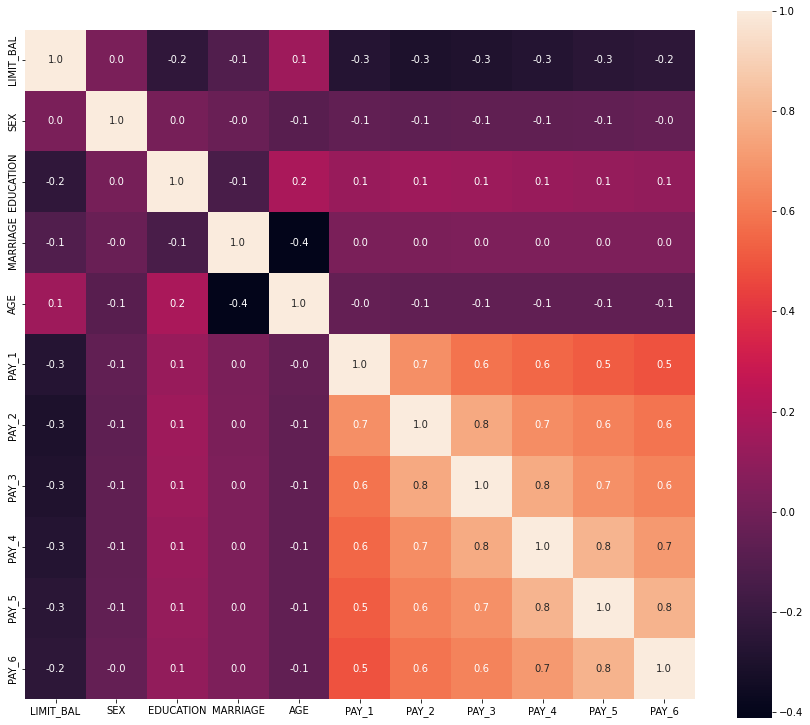

In [27]:
# Correlation matrix
var = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

f, ax = plt.subplots(figsize=(15, 13))
mydata = data[var]
mydata.corr()
# heatmap
corrmatrix = mydata.corr()
sns.heatmap(corrmatrix, square=True, annot=True, fmt=".1f")

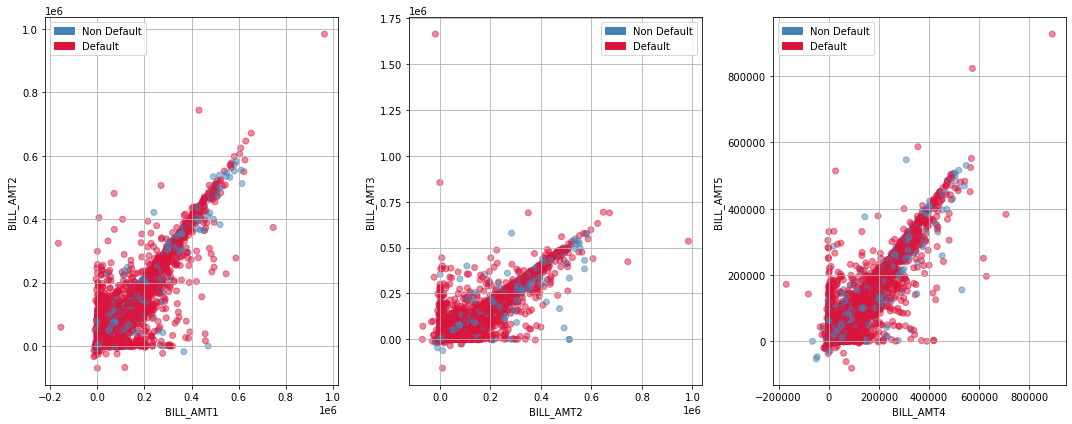

In [28]:
#distribution correlated features -- scatter interaction
import matplotlib.patches as mpatches


data_np=data.to_numpy()
target=data.Default

# variables to 
BILL_AMT1 = data['BILL_AMT1'].to_numpy()
BILL_AMT2 = data['BILL_AMT2'].to_numpy()
BILL_AMT3 = data['BILL_AMT3'].to_numpy()
BILL_AMT4 = data['BILL_AMT4'].to_numpy()
BILL_AMT5 = data['BILL_AMT5'].to_numpy()
BILL_AMT6 = data['BILL_AMT6'].to_numpy()
AGE = data['AGE'].to_numpy()
LIMIT_BAL = data['LIMIT_BAL'].to_numpy()
PAY_AMT1 = data['PAY_AMT1'].to_numpy()

fig, ax = plt.subplots(1,3, figsize= (15,6))

labels=["Non Default","Default"]
pop_a = mpatches.Patch(color='steelblue', label='Non Default')
pop_b = mpatches.Patch(color='crimson', label='Default')
colors=['crimson', 'steelblue']

ax[0].scatter(BILL_AMT1, BILL_AMT2, c=target, cmap=matplotlib.colors.ListedColormap(colors), label=labels, alpha=0.5)
ax[0].grid()
ax[0].set_xlabel('BILL_AMT1')
ax[0].set_ylabel('BILL_AMT2')
ax[0].legend(handles= [pop_a,pop_b])

ax[1].scatter(BILL_AMT2, BILL_AMT3, c=target, cmap=matplotlib.colors.ListedColormap(colors), alpha=0.5)
ax[1].grid()
ax[1].set_xlabel('BILL_AMT2')
ax[1].set_ylabel('BILL_AMT3')
ax[1].legend(handles= [pop_a,pop_b])

ax[2].scatter(BILL_AMT4,BILL_AMT5, c=target, cmap=matplotlib.colors.ListedColormap(colors), alpha=0.5)
ax[2].grid()
ax[2].set_xlabel('BILL_AMT4')
ax[2].set_ylabel('BILL_AMT5')
ax[2].legend(handles= [pop_a,pop_b])

plt.tight_layout()# let's make good plots
plt.show()


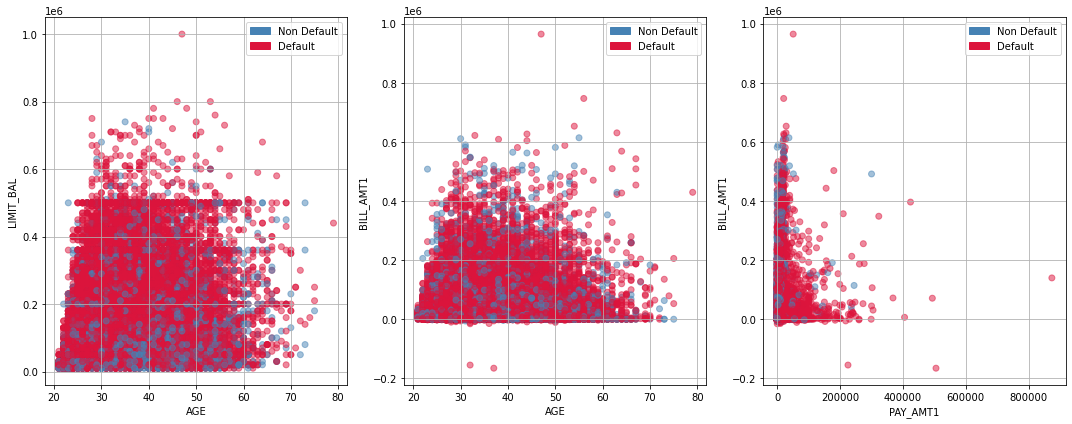

In [29]:
#distribution un-correlated features -- scatter interaction

fig, ax = plt.subplots(1,3, figsize= (15,6))

labels=["Non Default","Default"]
pop_a = mpatches.Patch(color='steelblue', label='Non Default')
pop_b = mpatches.Patch(color='crimson', label='Default')
colors=['crimson', 'steelblue']

ax[0].scatter(AGE, LIMIT_BAL, c=target, cmap=matplotlib.colors.ListedColormap(colors), label=labels, alpha=0.5)
ax[0].grid()
ax[0].set_xlabel('AGE')
ax[0].set_ylabel('LIMIT_BAL')
ax[0].legend(handles= [pop_a,pop_b])

ax[1].scatter(AGE, BILL_AMT1, c=target, cmap=matplotlib.colors.ListedColormap(colors), alpha=0.5)
ax[1].grid()
ax[1].set_xlabel('AGE')
ax[1].set_ylabel('BILL_AMT1')
ax[1].legend(handles= [pop_a,pop_b])

ax[2].scatter(PAY_AMT1,BILL_AMT1, c=target, cmap=matplotlib.colors.ListedColormap(colors), alpha=0.5)
ax[2].grid()
ax[2].set_xlabel('PAY_AMT1')
ax[2].set_ylabel('BILL_AMT1')
ax[2].legend(handles= [pop_a,pop_b])

plt.tight_layout()# let's make good plots
plt.show()


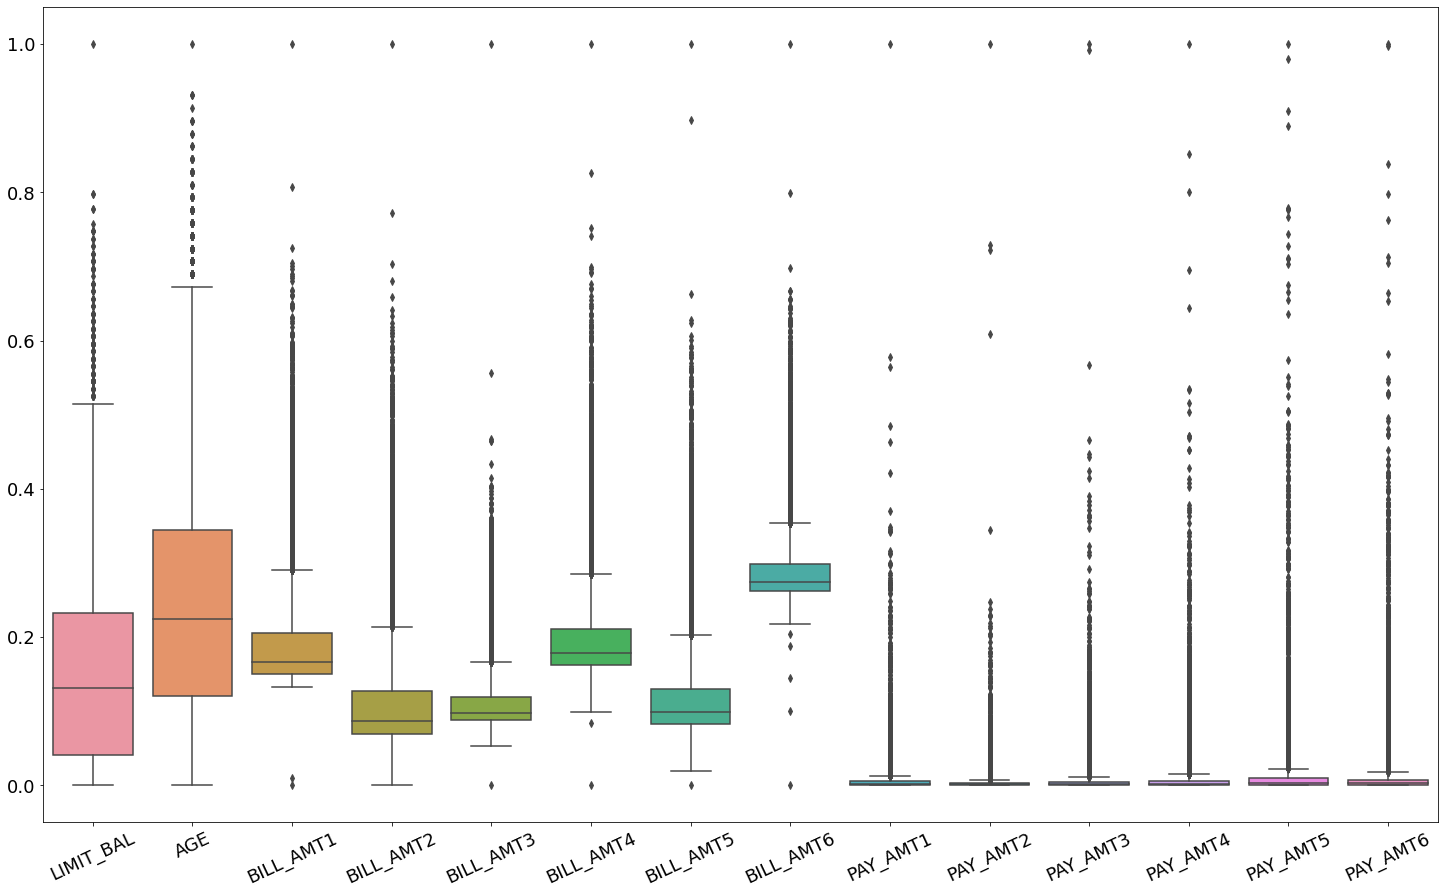

In [30]:
scaler = MinMaxScaler()
data['LIMIT_BAL'] = scaler.fit_transform(data['LIMIT_BAL'].values.reshape(-1, 1))
data['AGE'] = scaler.fit_transform(data['AGE'].values.reshape(-1, 1))

for i in range(1,7):
    scaler = MinMaxScaler()
    data['PAY_' + str(i)] = scaler.fit_transform(data['PAY_' + str(i)].values.reshape(-1, 1))

for i in range(1,7):
    scaler = MinMaxScaler()
    data['BILL_AMT' + str(i)] = scaler.fit_transform(data['BILL_AMT' + str(i)].values.reshape(-1, 1))

for i in range(1,7):
    scaler = MinMaxScaler()
    data['PAY_AMT' + str(i)] = scaler.fit_transform(data['PAY_AMT' + str(i)].values.reshape(-1, 1))
    
# BOXPLOT
cols = ['LIMIT_BAL','AGE','BILL_AMT1','BILL_AMT2','BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

fig=plt.figure(1, figsize=(25,15))
ax=fig.add_subplot(111)
sns.boxplot(data=data[cols])
plt.xticks(np.arange(0,14), labels=cols, rotation=25, fontsize=18)
plt.yticks(fontsize=18)
# plt.title('Boxplot', fontsize= 35)

plt.savefig('Fig - Boxplot')


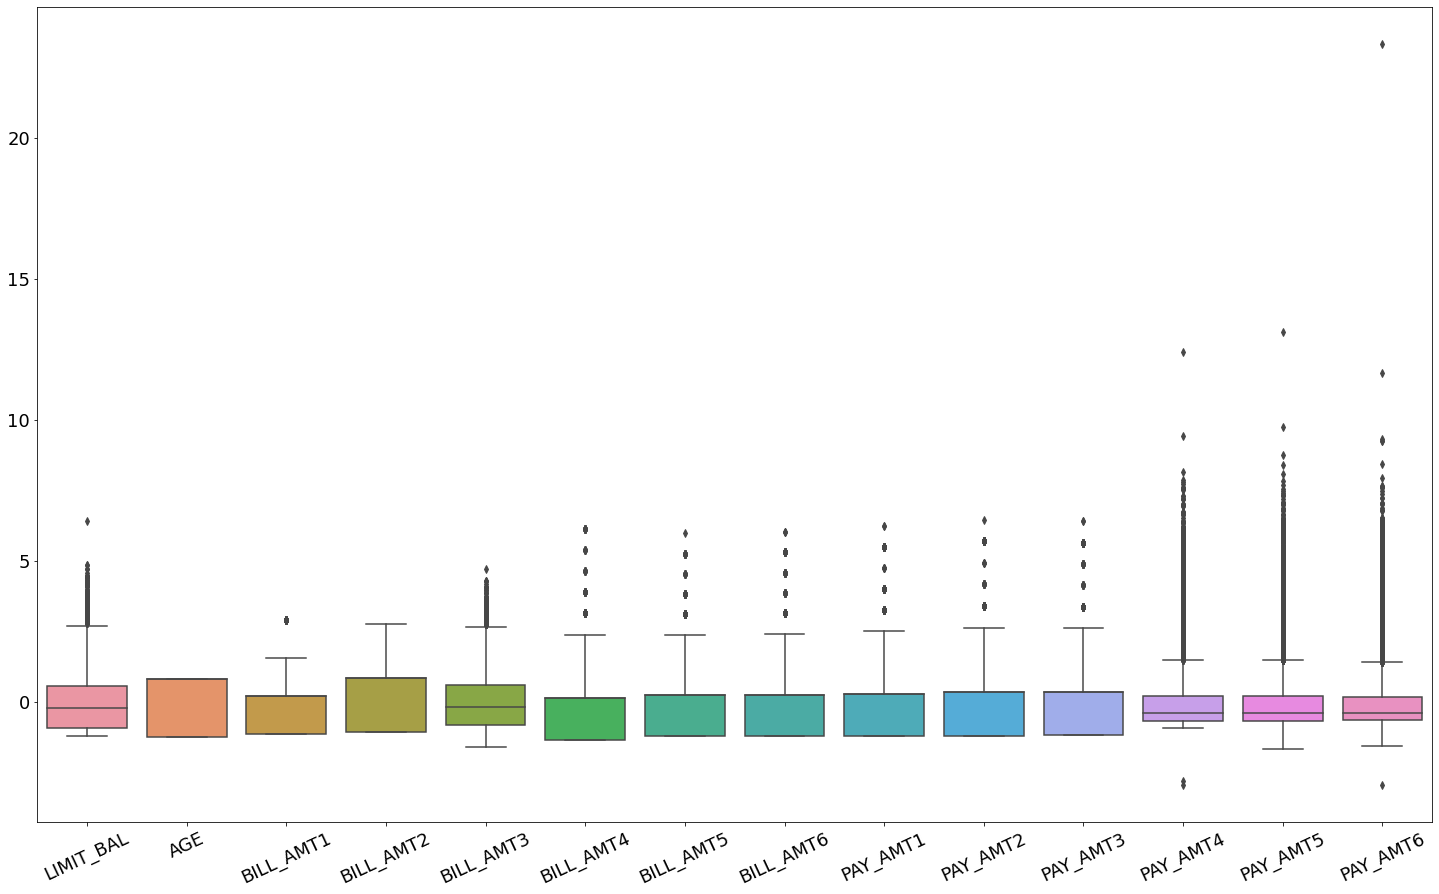

In [31]:
# Standard Scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# BOXPLOT
cols = ['LIMIT_BAL','AGE','BILL_AMT1','BILL_AMT2','BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

fig=plt.figure(1, figsize=(25,15))
ax=fig.add_subplot(111)
sns.boxplot(data=scaled_data[:,:-10])
plt.xticks(np.arange(0,14), labels=cols, rotation=25, fontsize=18)
plt.yticks(fontsize=18)
# plt.title('Boxplot', fontsize= 35)

plt.savefig('Fig - Boxplot Std Scaler')

In [32]:
# Set 'category' type to categorical attributes
for att in ['SEX', 'EDUCATION', 'MARRIAGE']:
  data[att] = data[att].astype('category')

# one-hot encoding
data=pd.concat([pd.get_dummies(data['SEX'], prefix='SEX'),
                pd.get_dummies(data['EDUCATION'], prefix='EDUCATION'), 
                pd.get_dummies(data['MARRIAGE'], prefix='MARRIAGE'),
                data],axis=1)
# drop original columns
data.drop(['EDUCATION'],axis=1, inplace=True)
data.drop(['SEX'],axis=1, inplace=True)
data.drop(['MARRIAGE'],axis=1, inplace=True)
# print samples
data.head()

,SEX_1,SEX_2,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,LIMIT_BAL,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Default
0,0,1,0,1,0,0,1,0,0,0.01,...,0.16,0.08,0.26,0.00e+00,4.09e-04,0.00e+00,0.00e+00,0.00e+00,0.00e+00,1
1,0,1,0,1,0,0,0,1,0,0.11,...,0.16,0.08,0.26,0.00e+00,5.94e-04,1.12e-03,1.61e-03,0.00e+00,3.78e-03,1
2,0,1,0,1,0,0,0,1,0,0.08,...,0.17,0.10,0.27,1.74e-03,8.91e-04,1.12e-03,1.61e-03,2.34e-03,9.46e-03,0
3,0,1,0,1,0,0,1,0,0,0.04,...,0.19,0.11,0.28,2.29e-03,1.20e-03,1.34e-03,1.77e-03,2.51e-03,1.89e-03,0
4,1,0,0,1,0,0,1,0,0,0.04,...,0.18,0.10,0.28,2.29e-03,2.18e-02,1.12e-02,1.45e-02,1.62e-03,1.28e-03,0


In [33]:
# Separating features and target
y = data.Default     # target default=1 or non-default=0
X = data.drop('Default', axis = 1, inplace = False)
# Check data set dimension
print(X.shape)
print("Number of samples:", X.shape[0])
print("Number of attributes:", X.shape[1])


(30000, 29)
Number of samples: 30000
Number of attributes: 29


# One Hot encoding for categorical variable

In [34]:
#categorical_vars = ['SEX','EDUCATION','MARRIAGE','PAY_1','PAY_2','PAY_3','PAY_4',
                   #'PAY_5','PAY_6']
#dataset[categorical_vars] = dataset[categorical_vars].astype(str)
#dataset = pd.get_dummies(dataset,columns=categorical_vars,drop_first=True)
#dataset.head()

In [35]:
data.shape


(30000, 30)

In [36]:
data.columns = data.columns.map(str.lower)

In [37]:
data.head()

,sex_1,sex_2,education_1,education_2,education_3,education_4,marriage_1,marriage_2,marriage_3,limit_bal,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default
0,0,1,0,1,0,0,1,0,0,0.01,...,0.16,0.08,0.26,0.00e+00,4.09e-04,0.00e+00,0.00e+00,0.00e+00,0.00e+00,1
1,0,1,0,1,0,0,0,1,0,0.11,...,0.16,0.08,0.26,0.00e+00,5.94e-04,1.12e-03,1.61e-03,0.00e+00,3.78e-03,1
2,0,1,0,1,0,0,0,1,0,0.08,...,0.17,0.10,0.27,1.74e-03,8.91e-04,1.12e-03,1.61e-03,2.34e-03,9.46e-03,0
3,0,1,0,1,0,0,1,0,0,0.04,...,0.19,0.11,0.28,2.29e-03,1.20e-03,1.34e-03,1.77e-03,2.51e-03,1.89e-03,0
4,1,0,0,1,0,0,1,0,0,0.04,...,0.18,0.10,0.28,2.29e-03,2.18e-02,1.12e-02,1.45e-02,1.62e-03,1.28e-03,0


### Step5: Feature Scaling of Numerical Attributes

In [38]:
col_to_norm = ['limit_bal', 'age', 'bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4',
       'bill_amt5', 'bill_amt6', 'pay_amt1', 'pay_amt2', 'pay_amt3',
       'pay_amt4', 'pay_amt5', 'pay_amt6']
data[col_to_norm] = data[col_to_norm].apply(lambda x : (x-np.mean(x))/np.std(x))

In [39]:
data.head(10)

,sex_1,sex_2,education_1,education_2,education_3,education_4,marriage_1,marriage_2,marriage_3,limit_bal,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default
0,0,1,0,1,0,0,1,0,0,-1.14,...,-0.67,-0.66,-0.65,-0.34,-0.23,-0.30,-0.31,-0.31,-0.29,1
1,0,1,0,1,0,0,0,1,0,-0.37,...,-0.62,-0.61,-0.60,-0.34,-0.21,-0.24,-0.24,-0.31,-0.18,1
2,0,1,0,1,0,0,0,1,0,-0.60,...,-0.45,-0.42,-0.39,-0.25,-0.19,-0.24,-0.24,-0.25,-0.01,0
3,0,1,0,1,0,0,1,0,0,-0.91,...,-0.23,-0.19,-0.16,-0.22,-0.17,-0.23,-0.24,-0.24,-0.24,0
4,1,0,0,1,0,0,1,0,0,-0.91,...,-0.35,-0.35,-0.33,-0.22,1.34,0.27,0.27,-0.27,-0.26,0
5,1,0,1,0,0,0,0,1,0,-0.91,...,-0.37,-0.34,-0.32,-0.19,-0.18,-0.26,-0.24,-0.25,-0.25,0
6,1,0,1,0,0,0,0,1,0,2.56,...,7.76,7.28,7.31,2.98,1.48,1.86,0.98,0.59,0.48,0
7,0,1,0,1,0,0,0,1,0,-0.52,...,-0.67,-0.67,-0.64,-0.32,-0.23,-0.30,-0.27,-0.20,-0.21,0
8,0,1,0,0,1,0,1,0,0,-0.21,...,-0.48,-0.47,-0.59,-0.14,-0.26,-0.27,-0.24,-0.25,-0.24,0
9,1,0,0,0,1,0,0,1,0,-1.14,...,-0.67,-0.45,-0.42,-0.34,-0.26,-0.30,0.52,-0.24,-0.29,0


In [40]:
data.tail(10)

,sex_1,sex_2,education_1,education_2,education_3,education_4,marriage_1,marriage_2,marriage_3,limit_bal,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default
29990,1,0,0,1,0,0,1,0,0,-0.21,...,1.48,0.15,0.12,0.02,0.05,-0.06,-0.21,-0.18,-0.18,0
29991,1,0,0,1,0,0,1,0,0,0.33,...,-0.63,-0.62,-0.61,-0.34,-0.26,-0.30,-0.31,-0.31,-0.29,1
29992,1,0,0,0,1,0,1,0,0,-1.21,...,-0.67,-0.66,-0.65,-0.22,-0.26,-0.30,-0.31,-0.31,-0.29,0
29993,1,0,1,0,0,0,0,1,0,-0.52,...,0.43,0.48,0.27,-0.22,4.59,-0.07,-0.12,-0.18,-0.18,0
29994,1,0,0,1,0,0,0,1,0,-0.67,...,0.53,0.70,0.71,0.08,-0.11,-0.30,0.14,-0.31,-0.07,1
29995,1,0,0,0,1,0,1,0,0,0.40,...,0.70,-0.15,-0.38,0.17,0.61,-0.01,-0.11,0.01,-0.24,0
29996,1,0,0,0,1,0,0,1,0,-0.13,...,-0.53,-0.58,-0.65,-0.23,-0.10,0.21,-0.30,-0.31,-0.29,0
29997,1,0,0,1,0,0,0,1,0,-1.06,...,-0.35,-0.32,-0.33,-0.34,-0.26,0.95,-0.04,-0.18,-0.12,1
29998,1,0,0,0,1,0,1,0,0,-0.67,...,0.15,-0.47,0.17,4.84,-0.11,-0.23,-0.19,3.15,-0.19,1
29999,1,0,0,1,0,0,1,0,0,-0.91,...,-0.10,-0.13,-0.40,-0.22,-0.18,-0.22,-0.24,-0.25,-0.24,1


### Step6: Spiliting Dataset into training(70%) and test set(30%)

In [41]:
X = data.iloc[:,:-1].values
y = data.iloc[:,-1].values

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state = 1)

In [42]:
X_train.shape

(21000, 29)

In [43]:
X_test.shape

(9000, 29)

### Step7: Applying Machine Learning Algorithm for Classification Problem

### Logistic Regression 
In Logistic Regression, we wish to model a dependent variable(Y) in terms of one or more independent variables(X). It is a method for classification. This algorithm is used for the dependent variable that is Categorical. Y is modeled using a function that gives output between 0 and 1 for all values of X. In Logistic Regression, the Sigmoid (aka Logistic) Function is used



In [44]:
from sklearn.linear_model import LogisticRegression
set_option('precision', 7)
logmodel = LogisticRegression(random_state=1, solver='lbfgs', max_iter=30000)
logmodel = logmodel.fit(X_train,y_train)

In [45]:
y_pred = logmodel.predict(X_test)

In [46]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

<AxesSubplot:>

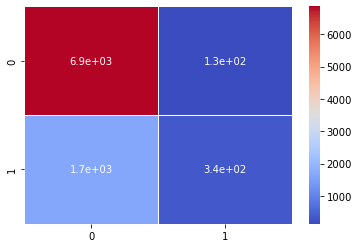

In [47]:
sns.heatmap(cm,annot= True,linewidths=1,cmap='coolwarm')

In [48]:
from sklearn.metrics import  accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
roc=roc_auc_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

model_results = pd.DataFrame([['Logistic Regression', acc,prec,rec, f1,roc]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score','ROC'])
model_results

,Model,Accuracy,Precision,Recall,F1 Score,ROC
0,Logistic Regression,0.8007778,0.7178947,0.1705,0.2755556,0.5756786


### Stochastic Gradient Descent
Stochastic Gradient Descent (SGD) is a simple yet very efficient approach to discriminative learning of linear classifiers under convex loss functions such as (linear) Support Vector Machines and Logistic Regression.It is on of the Gradient Descent Algorithm.It uses only a single example (a batch size of 1) per iteration. Given enough iterations, SGD works but is very noisy. The term "stochastic" indicates that the one example comprising each batch is chosen at random.

In [47]:
#from sklearn.linear_model import SGDClassifier
#sgd = SGDClassifier(loss='log', penalty='l1', learning_rate='optimal',random_state=1)
#sgd = sgd.fit(X_train, y_train)
#y_pred = sgd.predict(X_test)

In [48]:
#from sklearn.metrics import confusion_matrix
#cm = confusion_matrix(y_test, y_pred)

In [49]:
#sns.heatmap(cm,annot= True,linewidths=1,cmap='coolwarm')

In [50]:
#from sklearn.metrics import  accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
#roc=roc_auc_score(y_test, y_pred)
#acc = accuracy_score(y_test, y_pred)
#prec = precision_score(y_test, y_pred)
#rec = recall_score(y_test, y_pred)
#f1 = f1_score(y_test, y_pred)

#model = pd.DataFrame([['Stochastic Gradient Descent', acc,prec,rec, f1,roc]],
               #columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score','ROC'])
#model_results = model_results.append(model, ignore_index = True)
#model_results



### K-Nearest Neighbour
KNN can be used for both classification and regression predictive problems. However, it is more widely used in classification problems in the industry.

KNN focuses on easy implementation and good performance at the cost of computational time, but in our case the size of the dataset is considerably small so we can apply KNN.

We can implement a KNN model by following the below steps:

   * Load the data
   * Initialise the value of k
   * For getting the predicted class, iterate from 1 to total number of training data points
   * Calculate the distance between test data and each row of training data. Here we will use Euclidean distance as our distance metric since it’s the most popular method. The other metrics that can be used are Chebyshev, cosine, etc.
   * Sort the calculated distances in ascending order based on distance values
   * Get top k rows from the sorted array
   * Get the most frequent class of these rows
   * Return the predicted class
   

Let's go ahead and use the elbow method to pick a good K Value!

** Create a for loop that trains various KNN models with different k values, then keep track of the error_rate for each of these models with a list. Refer to the lecture if you are confused on this step.**

In [49]:
from sklearn.neighbors import KNeighborsClassifier

In [50]:
error_rate = []

# Will take some time
for i in range(1,40):
    
    knn = KNeighborsClassifier(n_neighbors=i,n_jobs=-1)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Error Rate')

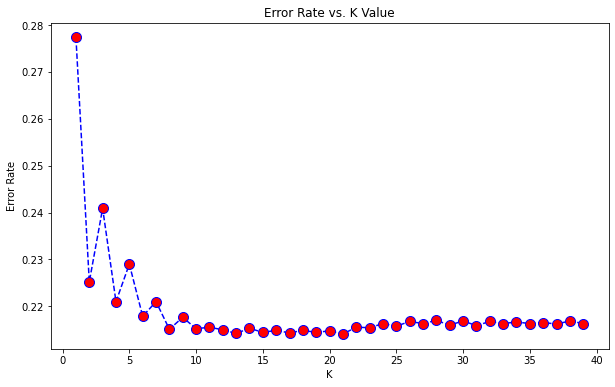

In [51]:
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [52]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=7)


In [53]:
knn = knn.fit(X_train,y_train)

In [54]:
y_pred = knn.predict(X_test)

In [55]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

<AxesSubplot:>

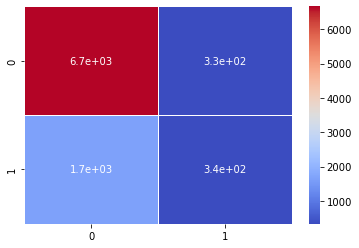

In [56]:
sns.heatmap(cm,annot= True,linewidths=1,cmap='coolwarm')

In [57]:
from sklearn.metrics import  accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
roc=roc_auc_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

res = pd.DataFrame([['K-Nearest Neighbour', acc,prec,rec, f1,roc]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score','ROC'])
model_results = model_results.append(res, ignore_index = True)
model_results

,Model,Accuracy,Precision,Recall,F1 Score,ROC
0,Logistic Regression,0.8007778,0.7178947,0.1705,0.2755556,0.5756786
1,K-Nearest Neighbour,0.7790000,0.5081967,0.1705,0.2553351,0.5616786


### Support Vector Machine
SVM or Support Vector Machine is a linear model for classification and regression problems. It can solve linear and non-linear problems.The algorithm creates a line or a hyperplane which separates the data into classes using different kernel tricks like = 'linear','rbf' (gaussian).

Thus SVM tries to make a decision boundary in such a way that the separation between the two classes(that street) is as wide as possible.


In [58]:
# Fitting SVM to the Training set
from sklearn.svm import SVC
scv = SVC(kernel = 'rbf', random_state = 0)
scv = scv.fit(X_train, y_train)

In [59]:
# Predicting the Test set results
y_pred = scv.predict(X_test)

In [60]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

<AxesSubplot:>

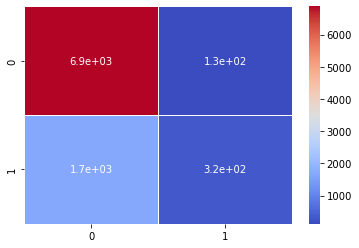

In [61]:
sns.heatmap(cm,annot= True,linewidths=1,cmap='coolwarm')

In [62]:
from sklearn.metrics import  accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
roc=roc_auc_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

model = pd.DataFrame([['Support Vector Machine', acc,prec,rec, f1,roc]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score','ROC'])
model_results = model_results.append(model, ignore_index = True)
model_results

,Model,Accuracy,Precision,Recall,F1 Score,ROC
0,Logistic Regression,0.8007778,0.7178947,0.1705,0.2755556,0.5756786
1,K-Nearest Neighbour,0.7790000,0.5081967,0.1705,0.2553351,0.5616786
2,Support Vector Machine,0.7994444,0.7181208,0.1605,0.2623621,0.5712500


### Gaussian Naive Bayes

In [63]:
from sklearn.naive_bayes import GaussianNB
naive_bayes = GaussianNB()
naive_bayes = naive_bayes.fit(X_train,y_train)

In [64]:
y_pred =naive_bayes.predict(X_test)

In [65]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

In [66]:
cm

array([[3258, 3742],
       [ 475, 1525]])

<AxesSubplot:>

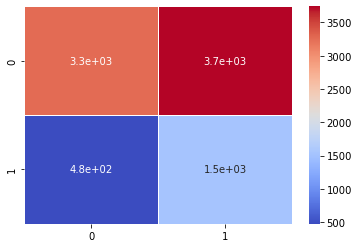

In [67]:
sns.heatmap(cm,annot= True,linewidths=1,cmap='coolwarm')

In [68]:
from sklearn.metrics import  accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
roc=roc_auc_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

model= pd.DataFrame([['Gaussian Naive Bayes', acc,prec,rec, f1,roc]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score','ROC'])
model_results = model_results.append(model, ignore_index = True)
model_results

,Model,Accuracy,Precision,Recall,F1 Score,ROC
0,Logistic Regression,0.8007778,0.7178947,0.1705,0.2755556,0.5756786
1,K-Nearest Neighbour,0.7790000,0.5081967,0.1705,0.2553351,0.5616786
2,Support Vector Machine,0.7994444,0.7181208,0.1605,0.2623621,0.5712500
3,Gaussian Naive Bayes,0.5314444,0.2895386,0.7625,0.4197055,0.6139643


### Decision Tree Classification
The idea of a decision tree is to divide the data set into smaller data sets based on the descriptive features until you reach a small enough set that contains data points that fall under one label.

#### Advantages of Decision Trees

Decision trees are easy to interpret.
To build a decision tree requires little data preparation from the user- there is no need to normalize data

#### Disadvantages of Decision Trees

Decision trees are likely to overfit noisy data. The probability of overfitting on noise increases as a tree gets deeper.


In [69]:
from sklearn.tree import DecisionTreeClassifier
dct = DecisionTreeClassifier(criterion = 'entropy',random_state = 0)

In [70]:
dct = dct.fit(X_train,y_train)

In [71]:
y_pred = dct.predict(X_test)

In [72]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

In [73]:
cm

array([[5794, 1206],
       [1183,  817]])

<AxesSubplot:>

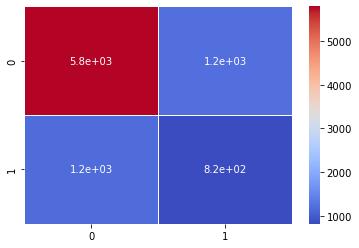

In [74]:
sns.heatmap(cm,annot= True,linewidths=1,cmap='coolwarm')

In [75]:
from sklearn.metrics import  accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
roc=roc_auc_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

model = pd.DataFrame([['Decision Tree Classifier', acc,prec,rec, f1,roc]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score','ROC'])
model_results = model_results.append(model, ignore_index = True)
model_results

,Model,Accuracy,Precision,Recall,F1 Score,ROC
0,Logistic Regression,0.8007778,0.7178947,0.1705,0.2755556,0.5756786
1,K-Nearest Neighbour,0.7790000,0.5081967,0.1705,0.2553351,0.5616786
2,Support Vector Machine,0.7994444,0.7181208,0.1605,0.2623621,0.5712500
3,Gaussian Naive Bayes,0.5314444,0.2895386,0.7625,0.4197055,0.6139643
4,Decision Tree Classifier,0.7345556,0.4038557,0.4085,0.4061646,0.6181071


### Random Forest Classification
Random Forest is a supervised learning algorithm, it creates a forest and makes it somehow random. The "forest“ it builds, is an ensemble of Decision Trees.

**Step1:-** Pick at random K data points from the training set

**Step2:-** Build the Decision tree associated to these K data points

**Step3:-** Choose the Number of trees(n) you want to build and repeat STEP1 and STEP2

**Step4:-** For a new data points make each one of your 'n' trees predict the category to which the data point belongs and assign the new data point to the category that wins the majority vote 

In [76]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators = 100,criterion = 'entropy',random_state = 0)

In [77]:
rfc = rfc.fit(X_train,y_train)

In [78]:
y_pred = rfc.predict(X_test)

In [79]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

In [80]:
cm

array([[6609,  391],
       [1290,  710]])

<AxesSubplot:>

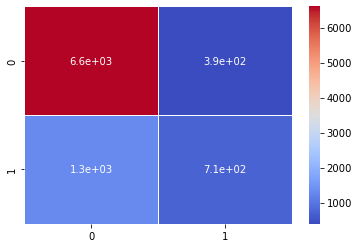

In [81]:
sns.heatmap(cm,annot= True,linewidths=1,cmap='coolwarm')

In [82]:
from sklearn.metrics import  accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
roc=roc_auc_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

results = pd.DataFrame([['Random tree Classifier', acc,prec,rec, f1,roc]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score','ROC'])

model_results = model_results.append(results, ignore_index = True)
model_results

,Model,Accuracy,Precision,Recall,F1 Score,ROC
0,Logistic Regression,0.8007778,0.7178947,0.1705,0.2755556,0.5756786
1,K-Nearest Neighbour,0.7790000,0.5081967,0.1705,0.2553351,0.5616786
2,Support Vector Machine,0.7994444,0.7181208,0.1605,0.2623621,0.5712500
3,Gaussian Naive Bayes,0.5314444,0.2895386,0.7625,0.4197055,0.6139643
4,Decision Tree Classifier,0.7345556,0.4038557,0.4085,0.4061646,0.6181071
5,Random tree Classifier,0.8132222,0.6448683,0.3550,0.4579168,0.6495714


### For Model Evaluation we are referreing Confusion Matrix
After we train a logistic regression model on some training data, we will evaluate the performance of the model on some test data. For this, we use the Confusion Matrix


the accuracy of the model : - ( TP + TN ) / Total

Here, TP stands for True Positive which are the cases in which we predicted yes and the actual value was true. TN stands for True Negative which are the cases in which we predicted no and the actual value was false.FP stands for False Positive which are the cases which we predicted yes and the actual value was False.FN stands for False Negative which are the cases which we predicted No and the actual value was true.

## Conclusion
1)Using a **Logistic Regression**  classifier, we can predict with **82.5% accuracy**, whether a customer is likely to default next month.

2)Using a **Stochastic Gradient Descent**  classifier, we can predict with **83.33% accuracy**, whether a customer is likely to default next month.

3)Using a **Support Vector Machine**  classifier, we can predict with **80.83% accuracy**, whether a customer is likely to default next month.

4)Using a **K-Nearest Neighbour**  classifier, we can predict with **80.83% accuracy**, whether a customer is likely to default next month.

5)Using a **Decision Tree  classifier**, we can predict with **82.83% accuracy**, whether a customer is likely to default next month.

6)Using a **Random Forest  classifier**, we can predict with **81% accuracy**, whether a customer is likely to default next month.

7)Using a **XGBOOST**  classifier, we can predict with **82.16% accuracy**, whether a customer is likely to default next month.


The strongest predictors of default are the **PAY_X (ie the repayment status in previous months), the LIMIT_BAL & the PAY_AMTX (amount paid in previous months)**.

**We found that using Stochastic Gradient Descent and Decision Tree are better.**

**Demographics**: we see that being Female, More educated, Single and between 30-40years old means a customer is more likely to make payments on time.